In [1]:
import cogent3
from cogent3 import get_app
import matplotlib.pyplot as plt
import paths
import libs
import pandas as pd

# CDS

I sampled chromosome 22 cds using 
```
eti homologs -i install/ --outdir cds --ref human --coord_names 22 
```
Then I trim stop codons and use a codon alignment model for all the sequences using
```
trim_stops = get_app("trim_stop_codons")
codon_align = get_app("progressive_align", "codon", guide_tree="(Human:0.06,Chimpanzee:0.06,Gorilla:0.1)")
```
I store the aligned sequences in the folder cds/codon_aligned/

In [2]:
folder_in = paths.DATA_APES114 + 'cds/codon_aligned'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

print(in_dstore.describe)

Directory datastore
record type      number
-----------------------
completed           345
not_completed        51
logs                  1
-----------------------


Load cds data

In [3]:
loader = get_app("load_aligned", moltype="dna")   
omit_degs_cds = get_app("omit_degenerates", moltype="dna", motif_length=3)
concat = get_app("concat", moltype="dna")

#create a concatenated alignment with all coding positions
cdsall_process = loader + omit_degs_cds
# result below is only valid alignments (no NotCompleted).
results_cdsall = [r for r in cdsall_process.as_completed(in_dstore[:], parallel=True) if r]
cdsall_alns = concat(results_cdsall)
cdsall_alns.source = "cds_alignments"
cdsall_alns

   0%|          |00:00<?

,0
Chimpanzee,ATGGCAAGCAAGGGGCCCTCGGCCTCTGCATCTCCTGAGAACTCCAGTGCAGGGGGGCCC
Gorilla,............................................................
Human,............................................................


Perform a General Nucleotide substitution model spliting codon positions.

In [4]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm_cds = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True, split_codons=True)
result_allpos = sm_cds(cdsall_alns)

lengthstree_pos1 = result_allpos[1].get_lengths_as_ens()
humanENS_pos1 = lengthstree_pos1['Human']

lengthstree_pos2 = result_allpos[2].get_lengths_as_ens()
humanENS_pos2 = lengthstree_pos2['Human']

lengthstree_pos3 = result_allpos[3].get_lengths_as_ens()
humanENS_pos3 = lengthstree_pos3['Human']

print("Distances: ")
print(lengthstree_pos1)
print(lengthstree_pos2)
print(lengthstree_pos3)

result_allpos.lf

   0%|          |00:00<?

   0%|          |00:00<?

   0%|          |00:00<?

   0%|          |00:00<?

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.006196983310782646), 'Chimpanzee': np.float64(0.005461408741706414), 'Human': np.float64(0.0032511517046072457)}
{'Gorilla': np.float64(0.0056458065867706205), 'Chimpanzee': np.float64(0.0051927931590279915), 'Human': np.float64(0.002686558206435089)}
{'Gorilla': np.float64(0.013925523402582175), 'Chimpanzee': np.float64(0.009903350671550166), 'Human': np.float64(0.007407092414209724)}


OrderedDict([(1,
              GN pos-1
              log-likelihood = -264487.7594
              number of free parameters = 39
              edge          parent    length     A>C     A>G     A>T     C>A     C>G
              ----------------------------------------------------------------------
              Gorilla       root        0.01    1.69    2.80    0.95    1.41    1.83
              Chimpanzee    root        0.01    1.19    2.17    0.88    1.18    1.17
              Human         root        0.00    1.54    4.68    0.84    1.68    2.24
              ----------------------------------------------------------------------
              
              continued: 
               C>T     G>A     G>C     G>T     T>A     T>C
              --------------------------------------------
              3.35    3.96    1.77    1.39    0.88    3.22
              1.88    2.61    1.67    0.85    0.86    1.85
              4.49    5.53    1.21    1.16    1.92    2.30
              -----------

In [5]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm_cds = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_cdsall = sm_cds(cdsall_alns)

lengthstree_cdsall = result_cdsall.lf.get_lengths_as_ens()
humanENS_cdsall = lengthstree_cdsall['Human']

print("Distances: ")
print(lengthstree_cdsall)

result_cdsall.lf

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.008566218261232418), 'Chimpanzee': np.float64(0.006845844668271654), 'Human': np.float64(0.004440723070062317)}


GN
log-likelihood = -817632.5312
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.01    1.22    3.24    0.79    1.18    1.64
Chimpanzee    root        0.01    0.99    2.08    0.76    0.87    1.20
Human         root        0.00    1.17    4.05    0.62    1.43    1.74
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
5.13    4.57    1.69    1.32    0.69    3.76
3.24    2.83    1.41    0.92    0.64    2.30
7.54    6.41    1.46    1.15    0.83    3.59
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.23    0.30    0.29    0.19
----------------------------

Perform a CpG substitution model using all cds positions.

In [6]:
cdsall_alns_forCpG = cdsall_alns.omit_gap_pos(motif_length=2, allowed_gap_frac=0.0)

#di_cpg defines a standard assymmetric dinucleotide model
di_cpg = get_app("model", libs.GDN_CpG(), time_het="max", show_progress=True, optimise_motif_probs=True)
result_cdsCpG = di_cpg(cdsall_alns_forCpG)

lengthstree_cdsCpG = result_cdsCpG.lf.get_lengths_as_ens()
humanENS_cdsCpG = lengthstree_cdsCpG["Human"]/2

print("Distances: ")
print(lengthstree_cdsCpG)

result_cdsCpG.lf

/home/u12/uliseshmc/.conda/envs/delme/lib/python3.13/site-packages/cogent3/recalculation/definition.py:690: UserWarning: using slow exponentiator because 'eigen failed precision test'
  return func(*args)


   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.017183624729443788), 'Chimpanzee': np.float64(0.013707394262802954), 'Human': np.float64(0.008897154575794411)}


GDN_CpG
log-likelihood = -808180.5895
number of free parameters = 57
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.02    1.22    3.23    0.79    1.18    1.64
Chimpanzee    root        0.01    0.99    2.06    0.76    0.87    1.20
Human         root        0.01    1.15    3.99    0.61    1.42    1.73
----------------------------------------------------------------------

continued: 
==============================================================
 C>T    CG>CA    CG>TG     G>A     G>C     G>T     T>A     T>C
--------------------------------------------------------------
4.05     4.40     4.61    3.64    1.69    1.32    0.69    3.75
2.69     4.18     3.80    2.28    1.41    0.91    0.63    2.28
6.10     4.56     4.12    5.03    1.46    1.14    0.82    3.50
--------------------------------------------------------------

============================================================================
  AA      AC      AG      AT      CA      CC      CG      CT      GA      GC
----------------------------------------------------------------------------
0.05    0.06    0.08    0.04    0.08    0.10    0.05    0.07    0.07    0.09
----------------------------------------------------------------------------

continued: 
============================================
  GG      GT      TA      TC      TG      TT
--------------------------------------------
0.09    0.04    0.02    0.06    0.08    0.04
--------------------------------------------

Load ffold positions from cds alignments

In [7]:
loader = get_app("load_aligned", moltype="dna")   
omit_degs_cds = get_app("omit_degenerates", moltype="dna", motif_length=3)
ffold = get_app("take_codon_positions", fourfold_degenerate=True)
concat = get_app("concat", moltype="dna")

#create a concatenated alignment with all coding positions
ffold_process = loader + omit_degs_cds + ffold
# result below is only valid alignments (no NotCompleted).
results_ffold = [r for r in ffold_process.as_completed(in_dstore[:], parallel=True) if r]
ffold_alns = concat(results_ffold)
ffold_alns.source = "cds_alignments"

ffold_alns

   0%|          |00:00<?

,0
Chimpanzee,GACTGGGAGAGCCCCGATCCCGGGCCTACTCCGGGTCCGCGCATTCGGTTGGACGACCCT
Gorilla,.................C..........................................
Human,.................C..........................................


Perfrom a GN substitution model on ffold positions

In [8]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_ffold = sm(ffold_alns)

lengthstree_ffold = result_ffold.lf.get_lengths_as_ens()
humanENS_ffold = lengthstree_ffold["Human"]

print("Distances: ")
print(lengthstree_ffold)

result_ffold.lf

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.014230381525532243), 'Chimpanzee': np.float64(0.008145817253298694), 'Human': np.float64(0.007866038314717884)}


GN
log-likelihood = -131955.0316
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.01    0.79    4.67    0.51    0.74    1.09
Chimpanzee    root        0.01    1.54    5.64    1.03    1.09    1.90
Human         root        0.01    1.06    4.01    0.39    0.78    0.97
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
4.15    5.22    1.43    0.90    0.39    4.05
8.29    9.78    1.50    1.71    1.00    6.22
5.22    6.17    1.18    0.84    0.31    2.71
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.15    0.38    0.31    0.16
----------------------------

# Introns

I sampled chromosome 22 introns masking ancestral repeats and cds using 
```
eti alignments -i install -od introns --align_name 10_primates* --ref human --mask cds_allAR_1column.txt --coord_names 22 
```
where cds_allAR_1column.txt is a list containing all the biotypes for ancestral repeats and cds

In [9]:
folder_in = paths.DATA_APES114 + 'introns/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

print(in_dstore.describe)

Directory datastore
record type      number
-----------------------
completed           543
not_completed         0
logs                  1
-----------------------


In [10]:
#loading and cocatanating sequences
loader = get_app("load_aligned", moltype="dna")
omit_degs_noncds = get_app("omit_degenerates", moltype="dna")
rename_noncds = libs.renamer_noncds_aligned()
concat = get_app("concat", moltype="dna")

noncds_app = loader + omit_degs_noncds + rename_noncds
#By using this renamer_aligned function I throw away sequences with paralogs
results_allpos = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alns_introns = concat(results_allpos)
alns_introns.source = "introns_alignments"
alns_introns

   0%|          |00:00<?

,0
Chimpanzee,AGCCACCCCCATCCCCTTCCCTCTTCCTGAGCACAGACATGGCTCCCCCACCTCCTCACA
Gorilla,................................................T...........
Human,............................................................


In [11]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_introns = sm(alns_introns)

lengthstree_introns = result_introns.lf.get_lengths_as_ens()
humanENS_intron = lengthstree_introns["Human"]

print("Distances: ")
print(lengthstree_introns)

result_introns.lf

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.009924377554952516), 'Chimpanzee': np.float64(0.006067051810905437), 'Human': np.float64(0.005807746090488716)}


GN
log-likelihood = -10543588.5646
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.01    1.01    4.67    0.64    1.17    1.64
Chimpanzee    root        0.01    0.98    3.66    0.61    1.02    1.51
Human         root        0.01    1.03    4.06    0.60    1.16    1.52
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
6.45    6.52    1.65    1.16    0.65    4.58
6.01    6.10    1.39    1.03    0.60    3.43
6.76    6.79    1.55    1.20    0.59    4.01
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.25    0.25    0.25    0.25
----------------------------

In [12]:
totalENS_introns = result_introns.total_length(length_as="ENS")
totalENS_introns

np.float64(0.02179917545634667)

In [13]:
#Do a CpG substitution model
alns_introns_forCpG = alns_introns.omit_gap_pos(motif_length=2, allowed_gap_frac=0.0)

di_cpg = get_app("model", libs.GDN_CpG(), time_het="max", show_progress=True, optimise_motif_probs=True)
result_intronsCpG = di_cpg(alns_introns_forCpG)

lengthstree_intronsCpG = result_intronsCpG.lf.get_lengths_as_ens()
humanENS_intronCpG = lengthstree_intronsCpG["Human"]/2

print("Distances: ")
print(lengthstree_intronsCpG)

result_intronsCpG.lf

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.019986751152591468), 'Chimpanzee': np.float64(0.012203966339393177), 'Human': np.float64(0.01167334677785289)}


GDN_CpG
log-likelihood = -10379746.5393
number of free parameters = 57
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.02    1.01    4.63    0.64    1.16    1.64
Chimpanzee    root        0.01    0.98    3.59    0.61    1.01    1.51
Human         root        0.01    1.03    3.96    0.60    1.16    1.52
----------------------------------------------------------------------

continued: 
==============================================================
 C>T    CG>CA    CG>TG     G>A     G>C     G>T     T>A     T>C
--------------------------------------------------------------
5.22     8.81     8.54    5.25    1.64    1.15    0.64    4.53
4.87     8.65     8.81    4.96    1.39    1.02    0.60    3.36
5.41     8.70     9.18    5.51    1.55    1.19    0.59    3.92
--------------------------------------------------------------

============================================================================
  AA      AC      AG      AT      CA      CC      CG      CT      GA      GC
----------------------------------------------------------------------------
0.07    0.05    0.08    0.05    0.08    0.08    0.02    0.08    0.06    0.06
----------------------------------------------------------------------------

continued: 
============================================
  GG      GT      TA      TC      TG      TT
--------------------------------------------
0.08    0.05    0.04    0.06    0.08    0.07
--------------------------------------------

# Intron AR sample alignment

I sampled chromosome 22 introns masking everythin but ancestral repeats using 
```
eti alignments -i install -od intronsAR --align_name 10_primates* --ref human --mask_shadow ancestralrepeats_1column.txt --coord_names 22 
```
where ancestralrepeats_1column.txt is a list containing the ancestral repeats biotypes: 
Type I Transposons/LINE,
Type I Transposons/SINE,
Type II Transposons,
LTRs

In [14]:
folder_in = paths.DATA_APES114 + 'intronsAR/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

print(in_dstore.describe)

Directory datastore
record type      number
-----------------------
completed           553
not_completed         0
logs                  1
-----------------------


In [15]:
#By using this renamer_aligned function I throw away sequences with paralogs
results_allpos = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alns_intronsAR = concat(results_allpos)
alns_intronsAR.source = "intronsAR_alignments"
alns_intronsAR

   0%|          |00:00<?

,0
Chimpanzee,CACTGGATTTGGGAGTCAGGAGCCTCACTCACCCCCACTCCACCCTTGAGTGACCTGGCC
Gorilla,...............................G............................
Human,............................................................


In [16]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_intronsAR = sm(alns_intronsAR)

lengthstree_intronsAR = result_intronsAR.lf.get_lengths_as_ens()
humanENS_intronAR = lengthstree_intronsAR["Human"]

print("Distances: ")
print(lengthstree_intronsAR)

result_intronsAR.lf

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.012073277760600333), 'Chimpanzee': np.float64(0.007186641285060655), 'Human': np.float64(0.006579166418585129)}


GN
log-likelihood = -8471315.4296
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.01    0.99    4.45    0.80    1.21    1.46
Chimpanzee    root        0.01    1.06    3.64    0.87    1.16    1.42
Human         root        0.01    0.99    3.83    0.71    1.21    1.50
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
6.77    6.95    1.43    1.16    0.78    4.33
7.40    7.40    1.36    1.21    0.81    3.51
7.53    7.70    1.36    1.25    0.72    3.84
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.26    0.24    0.24    0.26
----------------------------

In [17]:
totalENS_intronsAR = result_intronsAR.total_length(length_as="ENS")
totalENS_intronsAR

np.float64(0.02583908546424612)

In [18]:
#Do a CpG substitution model
alns_intronsAR_forCpG = alns_intronsAR.omit_gap_pos(motif_length=2, allowed_gap_frac=0.0)

di_cpg = get_app("model", libs.GDN_CpG(), time_het="max", show_progress=True, optimise_motif_probs=True)
result_intronsARCpG = di_cpg(alns_intronsAR_forCpG)

lengthstree_intronsARCpG = result_intronsARCpG.lf.get_lengths_as_ens()
humanENS_intronARCpG = lengthstree_intronsARCpG["Human"]/2

print("Distances: ")
print(lengthstree_intronsARCpG)

result_intronsARCpG.lf

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.024354644946283838), 'Chimpanzee': np.float64(0.014534220289106815), 'Human': np.float64(0.013286697979007344)}


GDN_CpG
log-likelihood = -8358327.9445
number of free parameters = 57
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.02    0.99    4.37    0.79    1.20    1.46
Chimpanzee    root        0.01    1.06    3.51    0.86    1.15    1.42
Human         root        0.01    0.99    3.66    0.71    1.20    1.50
----------------------------------------------------------------------

continued: 
==============================================================
 C>T    CG>CA    CG>TG     G>A     G>C     G>T     T>A     T>C
--------------------------------------------------------------
5.25     9.70     9.64    5.39    1.43    1.15    0.77    4.25
5.72    10.55    10.20    5.68    1.36    1.20    0.81    3.39
5.80    10.33    10.40    5.94    1.36    1.25    0.71    3.69
--------------------------------------------------------------

============================================================================
  AA      AC      AG      AT      CA      CC      CG      CT      GA      GC
----------------------------------------------------------------------------
0.08    0.05    0.08    0.06    0.08    0.07    0.02    0.08    0.06    0.06
----------------------------------------------------------------------------

continued: 
============================================
  GG      GT      TA      TC      TG      TT
--------------------------------------------
0.07    0.05    0.05    0.06    0.08    0.08
--------------------------------------------

# Intergenic sample alignment

I sampled chromosome 22 intergenic masking ancestral repeats and cds using 
```
eti alignments -i install -od intergenic --align_name 10_primates* --ref human --mask allAR_1column.txt --ref_coords chrom22-intergenic.tsv
```

where cds_allAR_1column.txt is the same as discussed in the intron section.

chrom22-intragenic.tsv is a table with intergenic regions coordinates. The instructions to make this table are discussed in "location_inter_intragenic.ipynb"


In [19]:
folder_in = paths.DATA_APES114 + 'intergenic/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

print(in_dstore.describe)

Directory datastore
record type      number
-----------------------
completed           706
not_completed         0
logs                  1
-----------------------


In [20]:
#By using this renamer_aligned function I throw away sequences with paralogs
results_inter = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alns_inter = concat(results_inter)
alns_inter.source = "intergenic_alignments"
alns_inter

   0%|          |00:00<?

,0
Chimpanzee,TATACACACAAAGGGCAAATGAAAAAATATGACGAAACACATGCGGGTCAATGCTATGGG
Gorilla,.........................................A..................
Human,............................................................


In [21]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_intergenic = sm(alns_inter)

lengthstree_intergenic = result_intergenic.lf.get_lengths_as_ens()
humanENS_inter = lengthstree_intergenic["Human"]

print("Distances: ")
print(lengthstree_intergenic)

result_intergenic.lf

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.01178540124840652), 'Chimpanzee': np.float64(0.007611661784599075), 'Human': np.float64(0.007351088408768515)}


GN
log-likelihood = -2982321.1610
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.01    0.95    4.33    0.67    1.18    1.52
Chimpanzee    root        0.01    0.98    3.69    0.66    1.12    1.48
Human         root        0.01    1.07    4.01    0.70    1.30    1.60
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
6.09    6.13    1.53    1.22    0.64    4.29
5.70    5.73    1.44    1.08    0.68    3.38
6.30    6.56    1.46    1.31    0.63    4.02
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.24    0.26    0.26    0.24
----------------------------

In [22]:
totalENS_intergenic = result_intergenic.total_length(length_as="ENS")
totalENS_intergenic

np.float64(0.02674815144177411)

In [23]:
#Do a CpG substitution model
alns_inter_forCpG = alns_inter.omit_gap_pos(motif_length=2, allowed_gap_frac=0.0)

di_cpg = get_app("model", libs.GDN_CpG(), time_het="max", show_progress=True, optimise_motif_probs=True)
result_interCpG = di_cpg(alns_inter_forCpG)

lengthstree_interCpG = result_interCpG.lf.get_lengths_as_ens()
humanENS_interCpG = lengthstree_interCpG["Human"]/2

print("Distances: ")
print(lengthstree_interCpG)

result_interCpG.lf

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.023767250547757343), 'Chimpanzee': np.float64(0.015343212944149465), 'Human': np.float64(0.014812736544722668)}


GDN_CpG
log-likelihood = -2931746.3411
number of free parameters = 57
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.02    0.95    4.26    0.67    1.17    1.52
Chimpanzee    root        0.02    0.98    3.58    0.65    1.11    1.47
Human         root        0.01    1.07    3.90    0.70    1.29    1.59
----------------------------------------------------------------------

continued: 
==============================================================
 C>T    CG>CA    CG>TG     G>A     G>C     G>T     T>A     T>C
--------------------------------------------------------------
4.82     8.98     9.45    4.89    1.52    1.20    0.63    4.23
4.49     9.04     9.87    4.59    1.43    1.07    0.68    3.28
5.05     9.24     9.17    5.24    1.46    1.30    0.62    3.89
--------------------------------------------------------------

============================================================================
  AA      AC      AG      AT      CA      CC      CG      CT      GA      GC
----------------------------------------------------------------------------
0.06    0.05    0.08    0.05    0.08    0.08    0.02    0.08    0.06    0.06
----------------------------------------------------------------------------

continued: 
============================================
  GG      GT      TA      TC      TG      TT
--------------------------------------------
0.08    0.05    0.04    0.06    0.08    0.06
--------------------------------------------

# Intergenic AR sample alignment

I sampled chromosome 22 intergenic regions masking everything but ancestral repeats using 
```
eti alignments -i install -od intragenicAR --align_name 10_primates* --ref human --mask_shadow ancestralrepeats_1column.txt --ref_coords chrom22-intragenic.tsv
```

where ancestralrepeats_1column.txt is the same as discussed in the introns AR section and chrom22-intragenic.tsv is the same as discussed in the intergenic section.

In [24]:
folder_in = paths.DATA_APES114 + 'intergenicAR/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

print(in_dstore.describe)

Directory datastore
record type      number
-----------------------
completed           701
not_completed         0
logs                  1
-----------------------


In [25]:
#By using this renamer_aligned function I throw away sequences with paralogs
results_interAR = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alns_interAR = concat(results_interAR)
alns_interAR.source = "intergenicAR_alignments"
alns_interAR

   0%|          |00:00<?

,0
Chimpanzee,CAGCTATTGCTCTACTCCTTCTCCCTTCCCAGCCCAGCTTCCCCAAAGAACTGTCTACTA
Gorilla,............................................................
Human,............................................................


In [26]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_intergenicAR = sm(alns_interAR)

lengthstree_intergenicAR = result_intergenicAR.lf.get_lengths_as_ens()
humanENS_interAR = lengthstree_intergenicAR["Human"]

print("Distances: ")
print(lengthstree_intergenicAR)

result_intergenicAR.lf

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.012639652632592197), 'Chimpanzee': np.float64(0.008387218697777352), 'Human': np.float64(0.0075960779491667475)}


GN
log-likelihood = -3638201.6185
number of free parameters = 39
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.01    0.93    4.27    0.66    1.22    1.41
Chimpanzee    root        0.01    1.04    3.52    0.89    1.19    1.42
Human         root        0.01    0.97    3.95    0.81    1.38    1.47
----------------------------------------------------------------------

continued: 
============================================
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
6.59    6.62    1.41    1.31    0.76    3.98
6.61    6.55    1.46    1.23    0.82    3.56
6.99    7.05    1.42    1.35    0.71    3.77
--------------------------------------------

============================
   A       C       G       T
----------------------------
0.26    0.23    0.23    0.27
----------------------------

In [27]:
totalENS_intergenicAR = result_intergenicAR.total_length(length_as="ENS")
totalENS_intergenicAR

np.float64(0.028622949279536295)

In [28]:
#Do a CpG substitution model
alns_interAR_forCpG = alns_interAR.omit_gap_pos(motif_length=2, allowed_gap_frac=0.0)

di_cpg = get_app("model", libs.GDN_CpG(), time_het="max", show_progress=True, optimise_motif_probs=True)
result_interARCpG = di_cpg(alns_interAR_forCpG)

lengthstree_interARCpG = result_interARCpG.lf.get_lengths_as_ens()
humanENS_interARCpG = lengthstree_interARCpG["Human"]/2

print("Distances: ")
print(lengthstree_interARCpG)

result_interARCpG.lf

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Gorilla': np.float64(0.025540917472429897), 'Chimpanzee': np.float64(0.016962724571204502), 'Human': np.float64(0.015344214967483083)}


GDN_CpG
log-likelihood = -3588789.9680
number of free parameters = 57
======================================================================
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Gorilla       root        0.03    0.92    4.19    0.66    1.21    1.40
Chimpanzee    root        0.02    1.04    3.40    0.88    1.18    1.42
Human         root        0.02    0.97    3.80    0.81    1.38    1.47
----------------------------------------------------------------------

continued: 
==============================================================
 C>T    CG>CA    CG>TG     G>A     G>C     G>T     T>A     T>C
--------------------------------------------------------------
5.07    10.22    10.92    5.17    1.41    1.29    0.75    3.91
5.15    10.36    10.84    5.16    1.46    1.22    0.81    3.43
5.60    10.65     9.81    5.52    1.42    1.34    0.71    3.61
--------------------------------------------------------------

============================================================================
  AA      AC      AG      AT      CA      CC      CG      CT      GA      GC
----------------------------------------------------------------------------
0.08    0.05    0.08    0.06    0.08    0.07    0.02    0.08    0.06    0.06
----------------------------------------------------------------------------

continued: 
============================================
  GG      GT      TA      TC      TG      TT
--------------------------------------------
0.07    0.05    0.05    0.06    0.08    0.08
--------------------------------------------

# Plotting

Text(0, 0.5, 'Constraint')

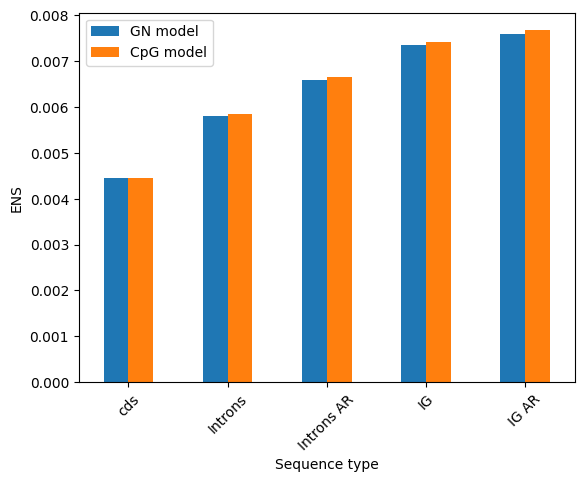

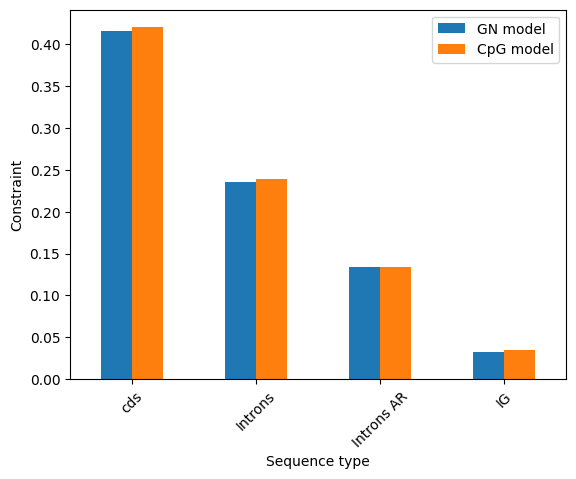

In [29]:
ENS_data = pd.DataFrame([
    ['cds', humanENS_cdsall, humanENS_cdsCpG],
    ['Introns', humanENS_intron, humanENS_intronCpG],
    ['Introns AR', humanENS_intronAR, humanENS_intronARCpG],
    ['IG', humanENS_inter, humanENS_interCpG],
    ['IG AR', humanENS_interAR, humanENS_interARCpG]
    ],
    columns = ['Sequence type', 'GN model', 'CpG model'])

Constraint_data = pd.DataFrame([
    ['cds', 1.0-humanENS_cdsall/humanENS_interAR, 1.0-humanENS_cdsCpG/humanENS_interARCpG],
    ['Introns', 1.0-humanENS_intron/humanENS_interAR, 1.0-humanENS_intronCpG/humanENS_interARCpG],
    ['Introns AR', 1.0-humanENS_intronAR/humanENS_interAR, 1.0-humanENS_intronARCpG/humanENS_interARCpG],
    ['IG', 1.0-humanENS_inter/humanENS_interAR, 1.0-humanENS_interCpG/humanENS_interARCpG]
    ],
    columns = ['Sequence type', 'GN model', 'CpG model'])

ENS_data.plot(x='Sequence type',
    kind = 'bar',
    rot=45,
    stacked=False)
plt.ylabel('ENS')

Constraint_data.plot(x='Sequence type',
    kind = 'bar',
    rot=45,
    stacked=False)
plt.ylabel('Constraint')


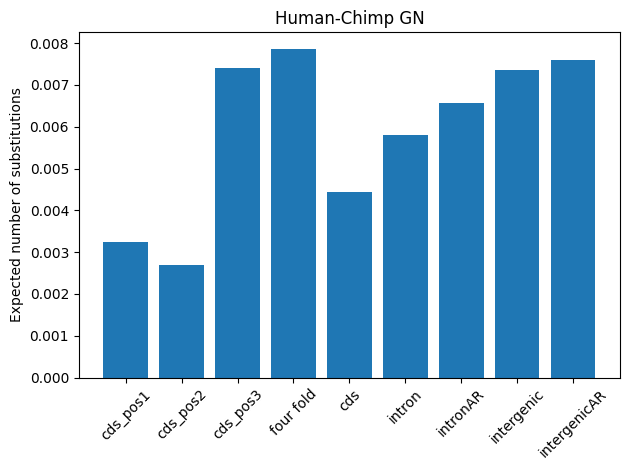

{'cds_pos1': np.float64(0.0032511517046072457), 'cds_pos2': np.float64(0.002686558206435089), 'cds_pos3': np.float64(0.007407092414209724), 'four fold': np.float64(0.007866038314717884), 'cds': np.float64(0.004440723070062317), 'intron': np.float64(0.005807746090488716), 'intronAR': np.float64(0.006579166418585129), 'intergenic': np.float64(0.007351088408768515), 'intergenicAR': np.float64(0.0075960779491667475)}


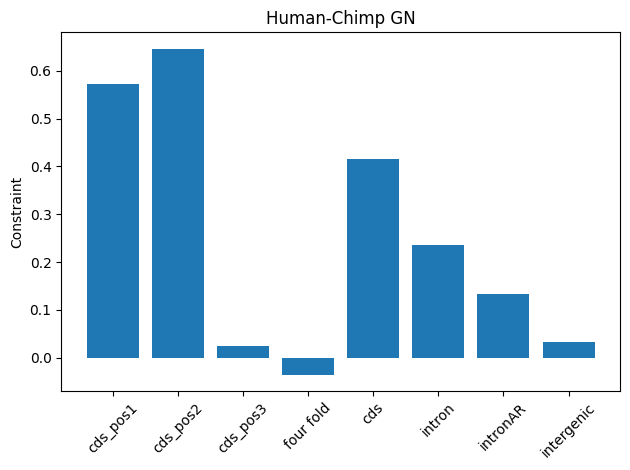

{'cds_pos1': np.float64(0.5719960055223128),
 'cds_pos2': np.float64(0.6463229808312076),
 'cds_pos3': np.float64(0.02487935698155308),
 'four fold': np.float64(-0.035539441190272525),
 'cds': np.float64(0.41539264081019045),
 'intron': np.float64(0.23542831848825385),
 'intronAR': np.float64(0.13387323529153206),
 'intergenic': np.float64(0.032252109843752486)}

In [31]:
ENS_human_GN = {
    "cds_pos1": humanENS_pos1,
    "cds_pos2": humanENS_pos2,
    "cds_pos3": humanENS_pos3,
    "four fold": humanENS_ffold,
    "cds": humanENS_cdsall,
    "intron": humanENS_intron,
    "intronAR": humanENS_intronAR,
    "intergenic": humanENS_inter,
    "intergenicAR": humanENS_interAR

}

constraint_GN = {
    "cds_pos1": 1-humanENS_pos1/humanENS_interAR,
    "cds_pos2": 1-humanENS_pos2/humanENS_interAR,
    "cds_pos3": 1-humanENS_pos3/humanENS_interAR,
    "four fold": 1-humanENS_ffold/humanENS_interAR,
    "cds": 1-humanENS_cdsall/humanENS_interAR,
    "intron": 1-humanENS_intron/humanENS_interAR,
    "intronAR": 1-humanENS_intronAR/humanENS_interAR,
    "intergenic": 1-humanENS_inter/humanENS_interAR
}

plt.figure()
plt.bar(ENS_human_GN.keys(), ENS_human_GN.values())
plt.ylabel("Expected number of substitutions")
plt.title("Human-Chimp GN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(ENS_human_GN)

plt.figure()
plt.bar(constraint_GN.keys(), constraint_GN.values())
plt.ylabel("Constraint")
plt.title("Human-Chimp GN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

constraint_GN

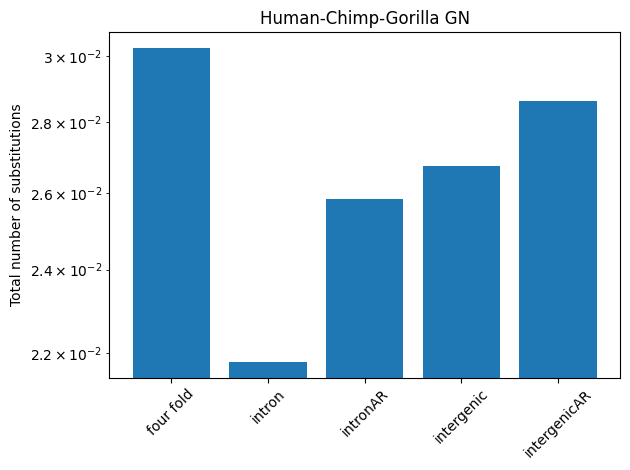

{'four fold': np.float64(0.030242240933041845), 'intron': np.float64(0.02179917548469741), 'intronAR': np.float64(0.025839089841548334), 'intergenic': np.float64(0.026748146830253994), 'intergenicAR': np.float64(0.028622952406617067)}


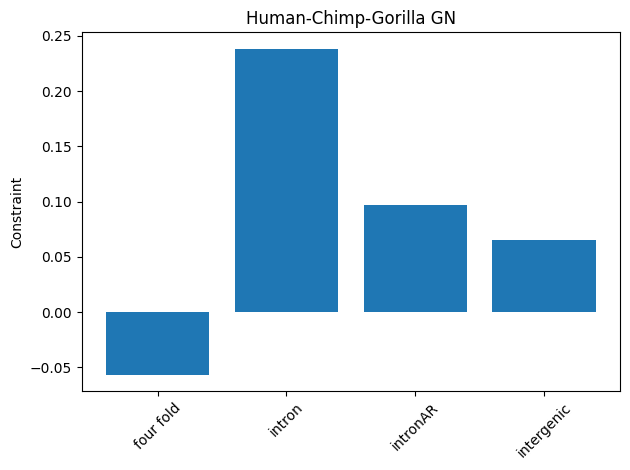

{'four fold': np.float64(-0.05657307825626101),
 'intron': np.float64(0.23840227328687913),
 'intronAR': np.float64(0.09725979785457628),
 'intergenic': np.float64(0.06550007664232615)}

In [ ]:
totalENS_human_GN = {
    "four fold": totalENS_ffold,
    "intron": totalENS_introns,
    "intronAR": totalENS_intronsAR,
    "intergenic": totalENS_intergenic,
    "intergenicAR": totalENS_intergenicAR
}

totalENS_constraint_GN = {
    "four fold": 1-totalENS_ffold/totalENS_intergenicAR,
    "intron": 1-totalENS_introns/totalENS_intergenicAR,
    "intronAR": 1-totalENS_intronsAR/totalENS_intergenicAR,
    "intergenic": 1-totalENS_intergenic/totalENS_intergenicAR
}

plt.figure()
plt.bar(totalENS_human_GN.keys(), totalENS_human_GN.values())
plt.ylabel("Total number of substitutions")
plt.title("Human-Chimp-Gorilla GN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(totalENS_human_GN)

plt.figure()
plt.bar(totalENS_constraint_GN.keys(), totalENS_constraint_GN.values())
plt.ylabel("Constraint")
plt.title("Human-Chimp-Gorilla GN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

totalENS_constraint_GN